# Detecting  Face & Facial landmarks(eyes, nose, and lips)






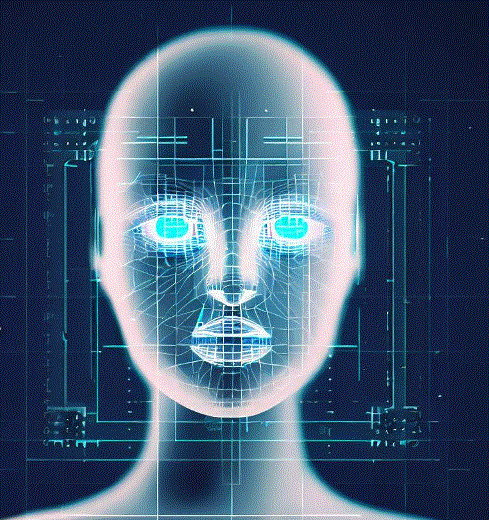

Commands are used to download a compressed file containing a facial landmark detection model and then decompress it

In [ ]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2


--2023-07-27 09:33:05--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  16.2MB/s    in 5.2s    

2023-07-27 09:33:10 (11.9 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



<IPython.core.display.Javascript object>

(480, 640)
Saved to photo_with_landmarks.jpg


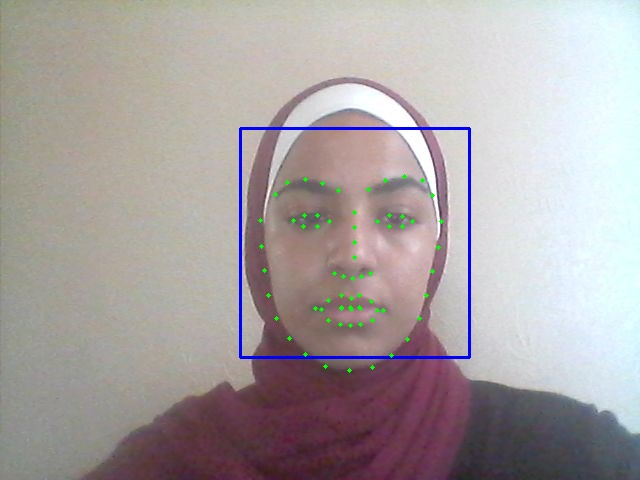

In [ ]:
# Import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import dlib

# Function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
    """
    Params:
        js_reply: JavaScript object containing image from webcam
    Returns:
        img: OpenCV BGR image
    """
    # Decode base64 image
    image_bytes = b64decode(js_reply.split(',')[1])
    # Convert bytes to numpy array
    jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
    # Decode numpy array into OpenCV BGR image
    img = cv2.imdecode(jpg_as_np, flags=1)

    return img

# Function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
    """
    Params:
        bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
    Returns:
        bytes: Base64 image byte string
    """
    # Convert array into PIL image
    bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
    iobuf = io.BytesIO()
    # Format bbox into png for return
    bbox_PIL.save(iobuf, format='png')
    # Format return string
    bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

    return bbox_bytes

# Initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

# Load the pre-trained facial landmark detection model
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# Function to detect facial landmarks
def detect_landmarks(gray_img, face_rect):
    """
    Params:
        gray_img: Grayscale image
        face_rect: Bounding box coordinates of the detected face
    Returns:
        landmarks: A list of tuples representing the (x, y) coordinates of the facial landmarks
    """
    shape = predictor(gray_img, face_rect)
    landmarks = [(shape.part(i).x, shape.part(i).y) for i in range(shape.num_parts)]
    return landmarks

def take_photo_with_landmarks(filename='photo_with_landmarks.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Resize the output to fit the video element.
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Wait for Capture to be clicked.
            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)

    # Get photo data
    data = eval_js('takePhoto({})'.format(quality))
    # Get OpenCV format image
    img = js_to_image(data)
    # Grayscale img
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    print(gray.shape)
    # Get face bounding box coordinates using Haar Cascade
    faces = face_cascade.detectMultiScale(gray)

    # Draw face bounding box on image and detect landmarks
    for (x, y, w, h) in faces:
        img = cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
        face_rect = dlib.rectangle(int(x), int(y), int(x + w), int(y + h))
        landmarks = detect_landmarks(gray, face_rect)

        # Draw circles on the detected facial landmarks (eyes, nose, and lips)
        for (x, y) in landmarks:
            img = cv2.circle(img, (x, y), 2, (0, 255, 0), -1)

    # Save image
    cv2.imwrite(filename, img)

    return filename

try:
    filename = take_photo_with_landmarks('photo_with_landmarks.jpg')
    print('Saved to {}'.format(filename))

    # Show the image with facial landmarks
    display(Image(filename))
except Exception as err:
    # Errors will be thrown if the user does not have a webcam or if they do not
    # grant the page permission to access it.
    print(str(err))
